In [25]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn import model_selection
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics

import nltk
from nltk.stem.snowball import SnowballStemmer
import ssl

import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
import itertools

In [58]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_ru')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/yarvod/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_ru to
[nltk_data]     /Users/yarvod/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_ru is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yarvod/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Base Data Preporation

In [3]:
with open('data/data.json') as f:
    data_raw = json.load(f)
    messages = [m['message'] for m in data_raw]
dfMessages = pd.DataFrame({'message': messages})
dfMessages = dfMessages.dropna()
dfMessages = dfMessages[~dfMessages.message.str.contains('#резюме')]
dfMessages

,message
0,
1,#вакансия\n\nTest Lead/Test Engineer/\nTechnic...
2,"#вакансия\n\nМладший аналитик\n\nМосква, м. Во..."
3,#вакансия\n\nMiddle React Native Front-Ender\n...
4,#вакансия\n\nНазвание компании: Сбер\n\nДолжно...
...,...
861,У меня есть Мега-парсер инсты. Разыскивается ф...
862,#job #вакансия\n\nАналитик или разработчик (ав...
863,#вакансия \nЛьвов —> Лос-Анджелес\nОфис (иногд...
864,#job #вакансия\nДолжность: Senior Android deve...


In [103]:
# На эти категории будет классифицировать предложения, в файле data/clear_labeled.csv я раскидал на нескольких лэйблы
class MessageBlocks:
    OTHER = 0  # мусор, то, что не распознать
    CONTACTS = 1  # контакт
    VACANCY_NAME = 2  # название вакансии
    COMPANY_NAME = 3  # название компании
    VACANCY_DESCRIPTION = 4  # описание вакансии
    COMPANY_DESCRIPTION = 5  # описание компании
    FORMAT = 6  # формат работы
    POSITION = 7  # позиция
    LEVEL = 8  # уровень позиции
    DUTIES = 9  # обязанности
    ADDRESS_OFFICE = 10  # адрес офиса
    REQUIREMENTS = 11  # требования
    SALARY = 12  # зарплата
    EMPLOYMENT = 13  # занятость
    SITE = 14  # сайт компании
    ADDITIONAL_INFO = 15  # доп информация
    STACK_TECH = 16  # стэк технологий
    WORK_CONDITIONS = 17  # условия работы
    LINK = 18  # какие-то ссылки
    HOW_APPLY = 19  # как откликаться
    POSITION_AND_SALARY = 20  # позиция и зарплата

    MAP = dict((
        (OTHER, 'Мусор'),
        (CONTACTS, 'Контакт'),
        (VACANCY_NAME, 'Название вакансии'),
        (COMPANY_NAME, 'Название компании'),
        (VACANCY_DESCRIPTION, 'Описание вакансии'),
        (COMPANY_DESCRIPTION, 'Описание компании'),
        (FORMAT, 'Формат работы'),
        (POSITION, 'Позиция'),
        (LEVEL, 'Уровень позции'),
        (DUTIES, 'Обязанности'),
        (ADDRESS_OFFICE, 'Адрес офиса'),
        (REQUIREMENTS, 'Требования'),
        (SALARY, 'Зарплата'),
        (EMPLOYMENT, 'Занятость'),
        (SITE, 'Сайт компании'),
        (ADDITIONAL_INFO, 'Доп. Информация'),
        (STACK_TECH, 'Стэк разработки'),
        (WORK_CONDITIONS, 'Условия работы'),
        (LINK, 'Ссылки'),
        (HOW_APPLY, 'Как откликнуться'),
        (POSITION_AND_SALARY, 'Позиция и зарплата'),
    ))
    

In [29]:
all_sentances = {'label': [], 'sentence': []}


def condition(s: str):
    if s == '':
        return False
    if '#' in s:
        return False
    return True

for row in dfMessages['message'].iloc[1:]:
    if row:
        sentances = [nltk.tokenize.sent_tokenize(s) for s in row.split('\n') if condition(s)]
        sentances = list(itertools.chain.from_iterable(sentances))
        labels = [0 for s in sentances]
        all_sentances['sentence'] += sentances
        all_sentances['label'] += labels

dfPrepared = pd.DataFrame(all_sentances)
dfPrepared.to_csv('data/clear.csv', index=False)
dfPrepared

,label,sentence
0,0,Test Lead/Test Engineer/
1,0,Technical Integration Consultant/
2,0,Functional Consultant/
3,0,Configuration Environment Management Consultant
4,0,"Город и адрес офиса: Кипр, Никосия"
...,...,...
21353,0,"Kristof Cools, assistant professor"
21354,0,Application form and more detailed description...
21355,0,https://www.academictransfer.com/en/290845/phd...
21356,0,Application deadline:


In [104]:
dfLabeled = pd.read_csv('data/clear_labeled.csv').iloc[:498]
dfLabeled.head(10)

,label,sentence
0,7,Test Lead/Test Engineer/
1,7,Technical Integration Consultant/
2,7,Functional Consultant/
3,7,Configuration Environment Management Consultant
4,10,"Город и адрес офиса: Кипр, Никосия"
5,6,"Формат работы: гибрид, 2/3 дня в неделю в офисе"
6,13,Занятость: полная
7,12,"Зарплатная вилка: от 2000 до 5000€, возможно и..."
8,4,Описание вакансии: подробные описания в брошюр...
9,3,Название компании: Murex


In [105]:
dfLabeled.tail(10)

,label,sentence
488,12,• ЗП: от $1000 до $1500 чистыми за 20 часов
489,6,• Удаленная работа
490,11,Требования:
491,11,"Python, C++, SQL"
492,9,Чем предстоит заниматься:
493,9,• разработка высоконагруженного Backend прилож...
494,9,• Чтение данных из Web Sockets
495,9,• Переезд с Python на C++
496,9,• Рефакторинг кода
497,1,Отзываться в ТГ: @ns1011


In [106]:
desc = dfLabeled.groupby('label').describe()
desc

sentence                                                               
         count unique                                                top freq
label                                                                        
0           24     19                                       Всем привет!    4
1           21     20          По всем вопросам писать в Telegram @k1rm1    2
2            7      7  Ищем амбициозных Middle PHP + Laravel разработ...    1
3           11     11                           Название компании: Murex    1
4           39     35  Мы работаем с онлайн-школами и корпоративными ...    2
5           25     25    Меня зовут Тим, CTO&CPO и основатель CentiMeta.    1
6           19     19    Формат работы: гибрид, 2/3 дня в неделю в офисе    1
7           25     25                           Test Lead/Test Engineer/    1
9           87     76                          Чем предстоит заниматься:    2
10          13     12  Локация: Москва, гибрид, удаленка +- 4 часа от...    2
11         109     95                                        Требования:    4
12          25     25  Зарплатная вилка: от 2000 до 5000€, возможно и...    1
13          14      9                                  Занятость: полная    3
14           4      4                       Сайт продукта: centimeta.org    1
15          15     15  Кстати, абсолютно норм, если ты студент старши...    1
16          12      7       Основные используемые технологии на проекте:    2
17          42     36                       Какие условия мы предлагаем:    2
19           3      3                             Откликаться по ссылке:    1
20           3      3  инженер по работе с данными (стажер / джун), 5...    1

## Preporation

In [107]:
text = np.array(dfLabeled.sentence.values)
target = dfLabeled.label.astype(int).values

In [108]:
def upperCaseRate(string):
    "Returns percentage of uppercase letters in the string"
    return np.array(list(map(str.isupper, string))).mean()

In [109]:
upcaseRate = list(map(upperCaseRate, dfLabeled.sentence.values))

In [110]:
def cleanText(string):
    """This function deletes all symbols except Cyrilic and Base Latin alphabet,
    stopwords, functional parts of speech. Returns string of words stem."""
    # Common cleaning
    string = string.lower()
    string = re.sub(r"http\S+", "", string)
    string = str.replace(string,'Ё','е')
    string = str.replace(string,'ё','е')
    prog = re.compile('[А-Яа-яA-Za-z]+')
    words = prog.findall(string.lower())
    
    # Word Cleaning
    ## Stop Words
    stopwords = nltk.corpus.stopwords.words('russian')
    words = [w for w in words if w not in stopwords]
    ## Cleaning functional POS (Parts of Speech)
    functionalPos = {'CONJ', 'PRCL'}
    words = [w for w, pos in nltk.pos_tag(words, lang='rus') if pos not in functionalPos]
    ## Stemming
    stemmer = SnowballStemmer('russian')
    return ' '.join(list(map(stemmer.stem, words)))

In [111]:
%%time
text = list(map(cleanText, text))

CPU times: user 465 ms, sys: 28 ms, total: 493 ms
Wall time: 493 ms


## Proccessing

In [112]:
X_train, X_test, y_train, y_test = train_test_split(text, target, test_size=.3, stratify=target, shuffle = True, random_state=0)
print('Dim of train:', len(X_train), '\tTarget rate: {:.2f}%'.format(y_train.mean()))
print("Dim of test:", len(X_test), '\tTarget rate: {:.2f}%'.format(y_test.mean()))

Dim of train: 348 	Target rate: 9.10%
Dim of test: 150 	Target rate: 9.13%


## Baseline

In [113]:
clf_pipeline = Pipeline(
            [("vectorizer", TfidfVectorizer()), # Prod feature: tokenizer=cleanText
            ("classifier", LinearSVC())]
        )

clf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('classifier', LinearSVC())])

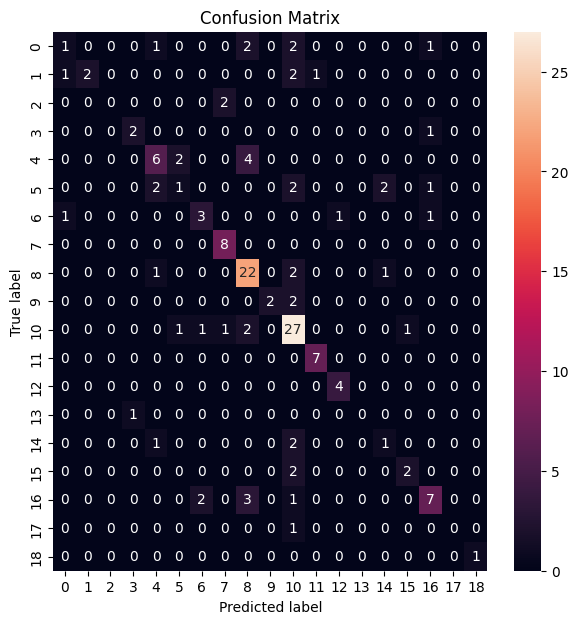

In [114]:
cm = metrics.confusion_matrix(y_test, clf_pipeline.predict(X_test))

def plotConfusionMatrix(cm):
    fig = plt.figure(figsize=(7,7))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return None

plotConfusionMatrix(cm)

In [115]:
print(metrics.classification_report(y_test, clf_pipeline.predict(X_test)))
f1_base = metrics.f1_score(y_test, clf_pipeline.predict(X_test), average='weighted')

              precision    recall  f1-score   support

           0       0.33      0.14      0.20         7
           1       1.00      0.33      0.50         6
           2       0.00      0.00      0.00         2
           3       0.67      0.67      0.67         3
           4       0.55      0.50      0.52        12
           5       0.25      0.12      0.17         8
           6       0.50      0.50      0.50         6
           7       0.73      1.00      0.84         8
           9       0.67      0.85      0.75        26
          10       1.00      0.50      0.67         4
          11       0.63      0.82      0.71        33
          12       0.88      1.00      0.93         7
          13       0.80      1.00      0.89         4
          14       0.00      0.00      0.00         1
          15       0.25      0.25      0.25         4
          16       0.67      0.50      0.57         4
          17       0.64      0.54      0.58        13
          19       0.00    

/Users/yarvod/workspace/phystech.job-projects/pj-nlp/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yarvod/workspace/phystech.job-projects/pj-nlp/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yarvod/workspace/phystech.job-projects/pj-nlp/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

## Work Test

In [117]:
dfTest = pd.read_csv('data/clear_labeled.csv').iloc[498:]
dfTest

,label,sentence
498,0,"tldr: qa-инженер в Тинькофф, Middle/Middle+/Se..."
499,0,Ищем 2 qa-инженеров в Тинькофф в команду мобил...
500,0,Мы работаем над созданием AI интерфейса платеж...
501,0,Основная цель команды — сделать суперудобный у...
502,0,Какими задачами нужно будет заниматься?
...,...,...
21311,0,"Kristof Cools, assistant professor"
21312,0,Application form and more detailed description...
21313,0,https://www.academictransfer.com/en/290845/phd...
21314,0,Application deadline:


In [118]:
testText = np.array(dfTest.sentence.values)

In [119]:
%%time
cleantext = list(map(cleanText, testText))

CPU times: user 18.3 s, sys: 1 s, total: 19.3 s
Wall time: 19.4 s


In [120]:
pr_labels = clf_pipeline.predict(cleantext)

In [121]:
blocks = [MessageBlocks.MAP[pr_label] for pr_label in pr_labels]
dfPredicted = pd.DataFrame({'label': pr_labels, 'block': blocks, 'sentence': testText, 'clean': cleantext})
dfPredicted.to_csv('data/predicted.csv', index=False)
dfPredicted

,label,block,sentence,clean
0,7,Позиция,"tldr: qa-инженер в Тинькофф, Middle/Middle+/Se...",tldr qa инженер тинькофф middle middle senior ...
1,0,Мусор,Ищем 2 qa-инженеров в Тинькофф в команду мобил...,ищ qa инженер тинькофф команд мобильн разработк
2,11,Требования,Мы работаем над созданием AI интерфейса платеж...,работа создан ai интерфейс платеж перевод кото...
3,4,Описание вакансии,Основная цель команды — сделать суперудобный у...,основн цел команд сдела суперудобн умн интерфе...
4,9,Обязанности,Какими задачами нужно будет заниматься?,как задач нужн занима
...,...,...,...,...
20813,11,Требования,"Kristof Cools, assistant professor",kristof cools assistant professor
20814,11,Требования,Application form and more detailed description...,application form and more detailed description...
20815,11,Требования,https://www.academictransfer.com/en/290845/phd...,
20816,11,Требования,Application deadline:,application deadline
